# Naive Bayes Classifier for Diabetes Prediction

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
class DiscreteNaiveBayes:
    def __init__(self, df, target_col='Diabetes_binary'):
        self.df = df.copy()
        self.target_col = target_col
        self.feature_probs = {}
        self.priors = {}

    def robust_scale_train_test(self, train_col, test_col):
        median = np.median(train_col)
        q1 = np.percentile(train_col, 25)
        q3 = np.percentile(train_col, 75)
        iqr = q3 - q1 + 1e-9
        return (train_col - median) / iqr, (test_col - median) / iqr

    def preprocess(self):
        X = self.df.drop(columns=[self.target_col])
        y = self.df[self.target_col]

        X['GenHlth'] = 6 - X['GenHlth']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

        num_cols = ['BMI', 'MentHlth', 'PhysHlth']
        for col in num_cols:
            X_train[col], X_test[col] = self.robust_scale_train_test(X_train[col], X_test[col])

        X_train[num_cols] = X_train[num_cols].round(0).astype(int)
        X_test[num_cols] = X_test[num_cols].round(0).astype(int)

        self.X_train = X_train.astype(int).values
        self.X_test = X_test.astype(int).values
        self.y_train = y_train.values
        self.y_test = y_test.values

    def fit(self):
        self.preprocess()

        self.priors = {
            0: np.sum(self.y_train == 0) / len(self.y_train),
            1: np.sum(self.y_train == 1) / len(self.y_train)
        }

        self.feature_probs = {0: {}, 1: {}}
        for label in [0, 1]:
            X_label = self.X_train[self.y_train == label]
            for col in range(self.X_train.shape[1]):
                values = np.unique(self.X_train[:, col])
                val_probs = {
                    val: (np.sum(X_label[:, col] == val) + 1) / (len(X_label) + len(values))
                    for val in values
                }
                self.feature_probs[label][col] = val_probs

        y_pred_train = self.predict(self.X_train)
        acc = accuracy_score(self.y_train, y_pred_train)
        cm = confusion_matrix(self.y_train, y_pred_train)
        return acc, cm

    def predict_probability(self, X):
        y_probs = []
        for x in X:
            p = {}
            for label in [0, 1]:
                prob = self.priors[label]
                for col in range(X.shape[1]):
                    val = x[col]
                    prob *= self.feature_probs[label][col].get(val, 1e-9)
                p[label] = prob
            total = p[0] + p[1]
            y_probs.append(p[1] / total if total > 0 else 0.5)
        return np.array(y_probs)

    def predict(self, X):
        return (self.predict_probability(X) >= 0.5).astype(int)

    def evaluate(self):
        y_pred = self.predict(self.X_test)
        acc = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        cm = confusion_matrix(self.y_test, y_pred)

        print(f"Accuracy: {acc:.4f}")
        print(f"Precision: {precision:.4f}")
        print(f"Recall: {recall:.4f}")
        print("Confusion Matrix:\n", cm)

        self.plot_confusion_matrix(cm)
        self.plot_roc_curve()
        return acc, cm

    def plot_confusion_matrix(self, cm):
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=['No Diabetes', 'Diabetes'],
                    yticklabels=['No Diabetes', 'Diabetes'])
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

    def plot_roc_curve(self):
        y_prob = self.predict_probability(self.X_test)
        fpr, tpr, _ = roc_curve(self.y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()

### Testing on Balanced Dataset

Accuracy: 0.7293
Precision: 0.7350
Recall: 0.7174
Confusion Matrix:
 [[5240 1829]
 [1998 5072]]


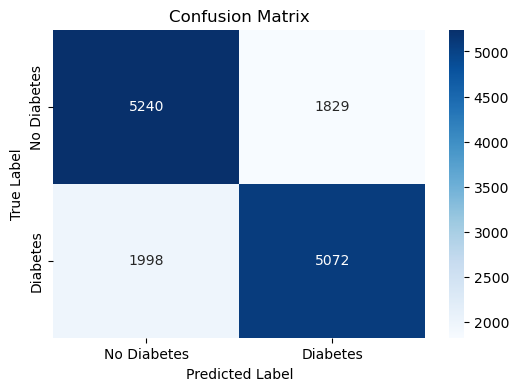

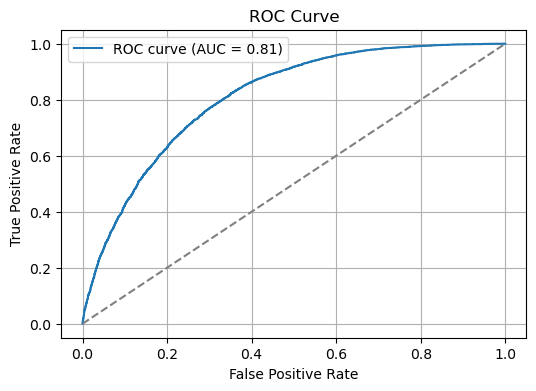

Train Accuracy: 0.7335 | Test Accuracy: 0.7293


In [4]:
diabetes_balanced = pd.read_csv(r"C:\Users\karni\OneDrive\Documents\GitHub\diabetes-classifier\data\diabetes_binary_5050split_health_indicators_BRFSS2015.csv")
model = DiscreteNaiveBayes(diabetes_balanced)
train_acc, train_cm = model.fit()
test_acc, test_cm = model.evaluate()
print(f"Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")